In [50]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [51]:
include("../../../util.j")

colnorm (generic function with 1 method)

In [52]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [53]:
#using Pkg
#Pkg.add("ProgressMeter");

In [54]:
@load "../data/sim1data.jld";

In [55]:
# priors #
K = 2;
μβ = fill(0.0, p, q); inv_Vr = [[0.0 0.0]; [0.0 0.0]];
μΛ = fill(0.0, K, q); inv_VΛ =[[0.0 0.0]; [0.0 0.0]];
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = [[0.0 0.0]; [0.0 0.0]]; Lμβ = inv_Lr * μβ;
inv_LΛ = [[0.0 0.0]; [0.0 0.0]]; LμΛ = inv_LΛ * μΛ;
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [56]:
# Some data preparations #
obs_ind = vcat(S, S .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S, S));                    # the vector of the permutation 

v1 = zeros(N); v1[S] .= 1;
v2 = zeros(N); v2[S] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
dim_invD = length(S) + length(S);
v12 = convert.(Int, v1 + v2);
v12_s = [x for x in v12 if x > 0];
nrep_ind = [x for i in v12 if i > 0 for x in repeat([i], i)];
invD_yind = [x for i in 1:length(nrep_ind) for x in repeat([perm_ind[i]], nrep_ind[i])];
invD_xind = Array{Float64}(undef, length(invD_yind));
indx_val = 1;
indx_pos = 1;
for i in 1:n
    indx = repeat(perm_ind[indx_val:(indx_val + v12_s[i] - 1)], v12_s[i]);
    invD_xind[indx_pos:(indx_pos + v12_s[i]^2 - 1)] = indx;
    indx_val = indx_val + v12_s[i];
    indx_pos = indx_pos + v12_s[i]^2;
end
Xtilde_indy_up = vcat(S, S .+ N);

In [57]:
# preallocation #

F = Array{Float64,2}(undef, n , K);                           # preallocate the matrix F, store the F before burn-in 
μ_m = Array{Float64, 2}(undef, N - n, q);
nIndx = length(NN.nnIndx);
A = [Array{Float64}(undef, nIndx) for i in 1:K];
D = [Array{Float64}(undef, n) for i in 1:K];
I_A = [spzeros(n, n) for i in 1:K];
A_new = [Array{Float64}(undef, nIndx) for i in 1:K];
D_new = [Array{Float64}(undef, n) for i in 1:K];
I_A_new = [spzeros(n, n) for i in 1:K];
Ystar = vcat(Y_ord[S, :], Lμβ, LμΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] spzeros(n, K)], [inv_Lr spzeros(p, K)], [spzeros(K, p) inv_LΛ]);
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);

invD_ele = Array{Float64}(undef, length(invD_xind));
invD = SparseMatrixCSC{Float64,Int64};
nsam = length(perm_ind) + (K * n);
Ytilde =  Array{Float64}(undef, nsam);
Xtilde = SparseMatrixCSC{Float64,Int64};
lll = fill(1.0, (n, 1));

In [9]:
# prediction preparison
NM = N - n;

# construct Atilde Dtilde #
using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho
Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
Mnndists = vec(nn_mod_ho[:nn_dists]');
lllM = fill(1.0, (NM, 1));

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [10]:
Sys.free_memory()/(2^20*1024)

21.354923248291016

In [11]:
using DelimitedFiles
writedlm("../results/BSLMC_γ_sam.csv", vcat([[0.0 0.0]; [0.0 0.0]; [0.0 0.0]], 
        [[1.0 0.0]; [0.0 1.0]]), ", ")
writedlm("../results/BSLMC_Σ_sam.csv", [[0.0 0.0]; [0.5 0.0]; [0.0 0.5]], ", ")
writedlm("../results/BSLMC_ω_cov_sam.csv", [[0.0 0.0]], ", ")

In [12]:
# Preallocation for MCMC samples and Initalization #
N_sam = 20000;
N_pre_burn = Integer(trunc(0.75 * N_sam));
N_pre_adapt = Integer(trunc(0.25 * N_sam));
N_after_burn = N_sam - N_pre_burn;

ω_incp_sam = Array{Float32, 2}(undef, n, q);
F_M_sam = Array{Float32, 2}(undef, NM, K);
ω_incp_M_sam = Array{Float32, 2}(undef, NM, q);
Y_M_sam = Array{Float32, 2}(undef, NM, q);

ω_incp_sam_mean = fill(0.0, n, q);
ω_incp_sam_var = fill(0.0, n, q);
ω_incp_M_sam_mean = fill(0.0, NM, q);
ω_incp_M_sam_var = fill(0.0, NM, q);
Y_M_sam_mean = fill(0.0, NM, q);
Y_M_sam_var = fill(0.0, NM, q);

A_sam = Array{Float32, 2}(undef, N_sam, K); # acceptance rate
lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges

ϕ_sam = Array{Float64, 2}(undef, K, N_sam + 1);

γ_sam = vcat([[0.0 0.0]; [0.0 0.0]], [[1.0 0.0]; [0.0 1.0]]);
Σ_sam = [[0.5 0.0]; [0.0 0.5]];
ω_cov_sam = [[0.5 0.0]; [0.0 0.5]];
ϕ_sam[:, 1] = [6.0, 18.0];#[6, 30];

RWM_scale = [0.1, 0.1];                                              # random-walk metropolis step size scale 

In [13]:
Sys.free_memory()/(2^20*1024)

21.357406616210938

In [14]:
# for loop for MCMC chain #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => (1 / sqrt(Σ_sam[:, :][1, 1])), 
        2^1 => (1 / sqrt(Σ_sam[:, :][2, 2])), 
        (2^0 + 2^1)=> (sqrt(inv(Σ_sam[:, :]))));
    invD_ele = [x for i in index_S if i > 0 for x in Dic_diag[i]];
    invD = sparse(invD_xind, invD_yind, invD_ele);
                    
    # Build the matrix for the first iteration #
    if l == 1
        for i in 1:K
            getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[i], 0.5, A[i], D[i]);
            I_A[i] = sparse(nnIndx_row, nnIndx_col, vcat(-A[i], ones(n)));
        end
    end
                    

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S, 1] - X_ord[S, :] * γ_sam[1:p, 1], 
                            Y_ord[S, 2] - X_ord[S, :] * γ_sam[1:p, 2]), zeros(K * n));
    Xtilde = vcat(invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, Xtilde_indy_up],
             blockdiag(Diagonal(1 ./ sqrt.(D[1])) * I_A[1], Diagonal(1 ./ sqrt.(D[2])) * I_A[2]));
                
    # use LSMR to generate sample of F #       
    #Precond_D = colnorm(Xtilde);
    #F_sam = reshape(Diagonal(1 ./ Precond_D) * lsmr(Xtilde * Diagonal(1 ./ Precond_D), 
    #        collect(Ytilde) + rand(Normal(), nsam)), :, K);  
    F_sam = reshape(lsmr(Xtilde, collect(Ytilde) + rand(Normal(), nsam)), :, K);
    Xstar[1:n, (p + 1):(p + K)] = F_sam;        # update matrix Xstar with F
                    
    if(l > N_pre_burn) # only save ω_incp_sam after burn-in
        ω_incp_sam = F_sam * γ_sam[(p + 1):(p + K), :] + lll * transpose(γ_sam[1, :]); 
        ω_incp_sam_mean = ω_incp_sam_mean + (ω_incp_sam ./ N_after_burn);
        ω_incp_sam_var = ω_incp_sam_var + (ω_incp_sam.^2 ./ N_after_burn);  
        ω_cov_sam = cov(ω_incp_sam);
    else
        ω_cov_sam = cov(F_sam * γ_sam[(p + 1):(p + K), :]);
    end                    
    io1 = open("../results/BSLMC_ω_cov_sam.csv", "a" ); # covariance of latent process
    writedlm(io1, ω_cov_sam, ", ");
    close(io1);
                                       
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    #Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    Y_Xm = Ystar - Xstar * μγstar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) *
                    cholesky(Σ_sam).U + μγstar;          # sample γ    
    io4 = open("../results/BSLMC_Σ_sam.csv", "a" );
    writedlm(io4, Σ_sam, ", ");
    close(io4); 
    io5= open("../results/BSLMC_γ_sam.csv", "a" );
    writedlm(io5, γ_sam, ", ");
    close(io5)                
                    
    # use metropolis-hasting to update range
    if l > 3 && l < N_pre_adapt
        RWM_scale = [sqrt(2.38^2 * var(ϕ_sam[i, Integer(floor(l / 2)):l], 
                                    corrected=true) * 0.95^2 + 0.05^2 * 0.1^2) 
                            for i in 1:K];
    end
    ϕ_sam[:, l + 1] = [ϕ_sam[i, l] + RWM_scale[i] * rand(Normal(), 1)[1] for i in 1:K]; # propose next sample point
    
    for i in 1:K
        if (ϕ_sam[i, l + 1] > ϕL && ϕ_sam[i, l + 1] < ϕU)
            lh_old = -0.5 * (sum(log.(D[i])) + norm((I_A[i] * F_sam[:, i]) ./ sqrt.(D[i]))^2); 
                            #+ loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l]]);
            getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[i, l + 1], 0.5, A_new[i], D_new[i]);
            I_A_new[i] = sparse(nnIndx_row, nnIndx_col, vcat(-A_new[i], ones(n)));
            lh_new = -0.5 * (sum(log.(D_new[i]))  + norm((I_A_new[i] * F_sam[:, i]) ./ sqrt.(D_new[i]))^2);
                            #+ loglikelihood(Gamma(aϕ[i], bϕ[i]), [ϕ_sam[i, l + 1]]);     
            A_sam[l, i] = min(exp(lh_new - lh_old), 1.0);
            if rand(1)[1] < A_sam[l, i]
                I_A[i] = copy(I_A_new[i]); D[i] = copy(D_new[i]);        # update and update the corresponding I_A D
            else 
                ϕ_sam[i, l + 1] = ϕ_sam[i, l];
            end
        else 
            A_sam[l, i] = 0.0;
            ϕ_sam[:, l + 1] = ϕ_sam[:, l];   
        end
    end
                    
    
    # Prediction:
    if(l > N_pre_burn) 
        for j in 1:K
            getAD(coords_ord[:, S], MnnIndx, Mnndists, MnnIndxLU, ϕ_sam[j, l + 1], 0.5, Atilde, Dtilde);
            AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde, NM, n);
            F_M_sam[:, j] = AtildeM * F_sam[:, j] + sqrt.(Dtilde) .* rand(Normal(), NM);
        end
        ω_incp_M_sam = F_M_sam * γ_sam[(p + 1):(p + K), :] + lllM * transpose(γ_sam[1, :]);
        ω_incp_M_sam_mean = ω_incp_M_sam_mean + (ω_incp_M_sam ./ N_after_burn);
        ω_incp_M_sam_var = ω_incp_M_sam_var + (ω_incp_M_sam.^2 ./ N_after_burn);
        # update Y
        Y_M_sam = X_ord[M, 2:p] * γ_sam[2:p, :] + ω_incp_M_sam + 
                        transpose(rand(MvNormal(Σ_sam), NM));
        Y_M_sam_mean = Y_M_sam_mean + (Y_M_sam ./ N_after_burn);
        Y_M_sam_var = Y_M_sam_var + (Y_M_sam.^2 ./ N_after_burn);
    end
    next!(prog) # monitor the progress
end
ω_incp_sam_var = ω_incp_sam_var - ω_incp_sam_mean.^2;
ω_incp_M_sam_var = ω_incp_M_sam_var - ω_incp_M_sam_mean.^2;
Y_M_sam_var = Y_M_sam_var - Y_M_sam_mean.^2;    

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:03:162:56


In [15]:
round.([mean(A_sam[(N_pre_burn + 1):N_sam, i]) for i in 1:K], digits = 5)

2-element Array{Float32,1}:
 0.15857
 0.18428

In [16]:
RWM_scale

2-element Array{Float64,1}:
 1.912654829955909
 2.685679597316043

In [58]:
#load data
using CSV
γ_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_γ_sam.csv"));
ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_Σ_sam.csv"));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, CSV.read("../results/BSLMC_ω_cov_sam.csv"));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);

Posterior prediction

# MCMC Chain check

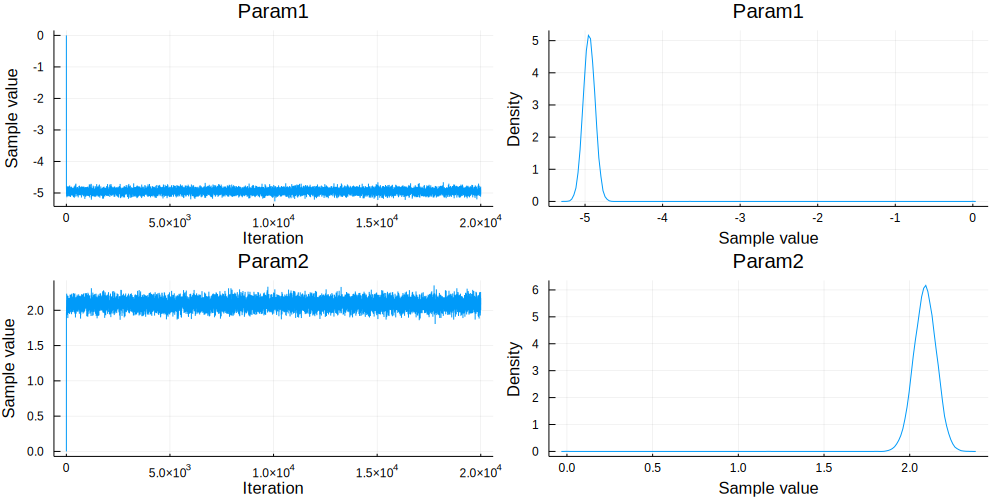

In [18]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, (p - 1) * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[ind_γ_sam .+ 1, 1], γ_sam[ind_γ_sam .+ 1, 2]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [19]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

In [20]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * (q - 1), 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[ind_γ_sam .+ 2, 1], 
    γ_sam[ind_γ_sam .+ 2, 2], 
    #γ_sam[ind_γ_sam .+ 3, 1], 
    #γ_sam[ind_γ_sam .+ 3, 2]
    );
Λ_chain = Chains(Λ_pos_sam);
#pΛ = plot(Λ_chain);

In [59]:
Λ

UndefVarError: UndefVarError: Λ not defined

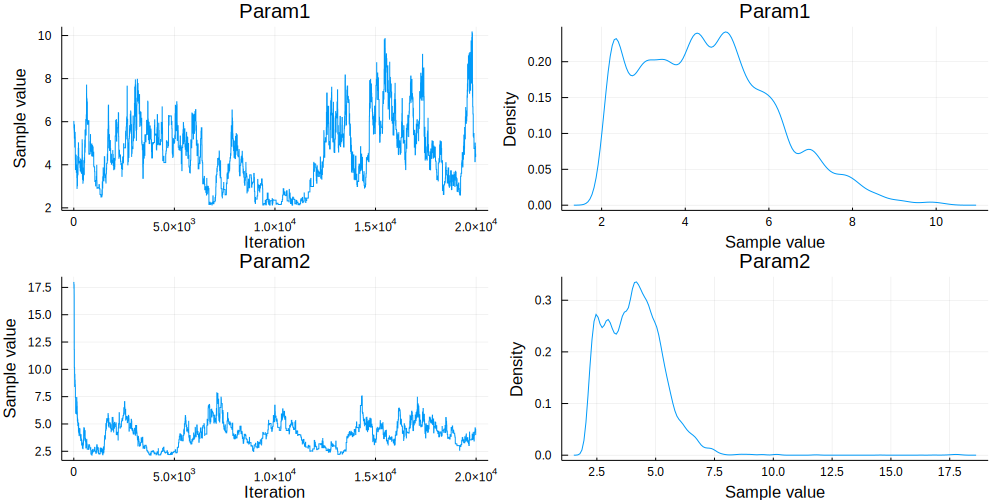

In [22]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat(ϕ_sam[1, :][1:(N_sam + 1)], ϕ_sam[2, :][1:(N_sam + 1)]);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

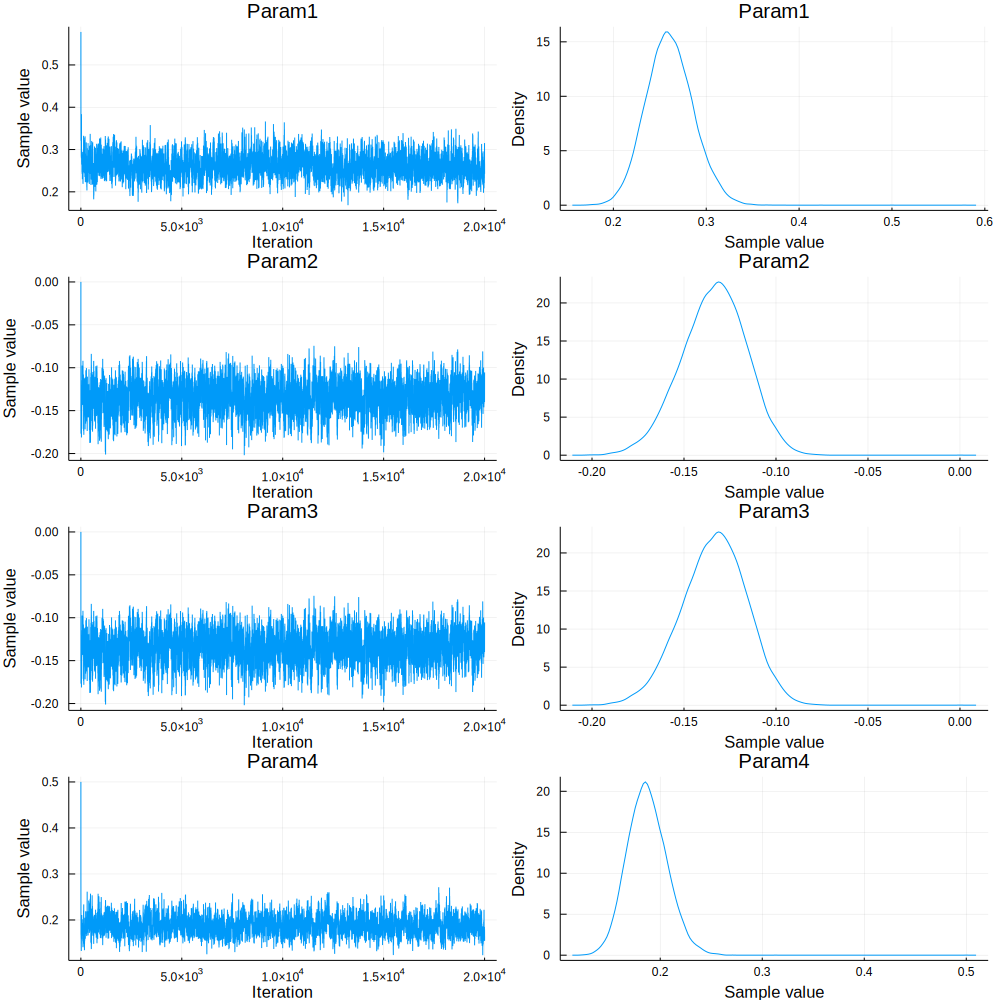

In [23]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[ind_Σ_sam, 1], Σ_sam[ind_Σ_sam, 2], 
    Σ_sam[ind_Σ_sam .+ 1, 1], Σ_sam[ind_Σ_sam .+ 1, 2]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [24]:
Σ

2×2 Array{Float64,2}:
  2.0  -1.0
 -1.0   1.5

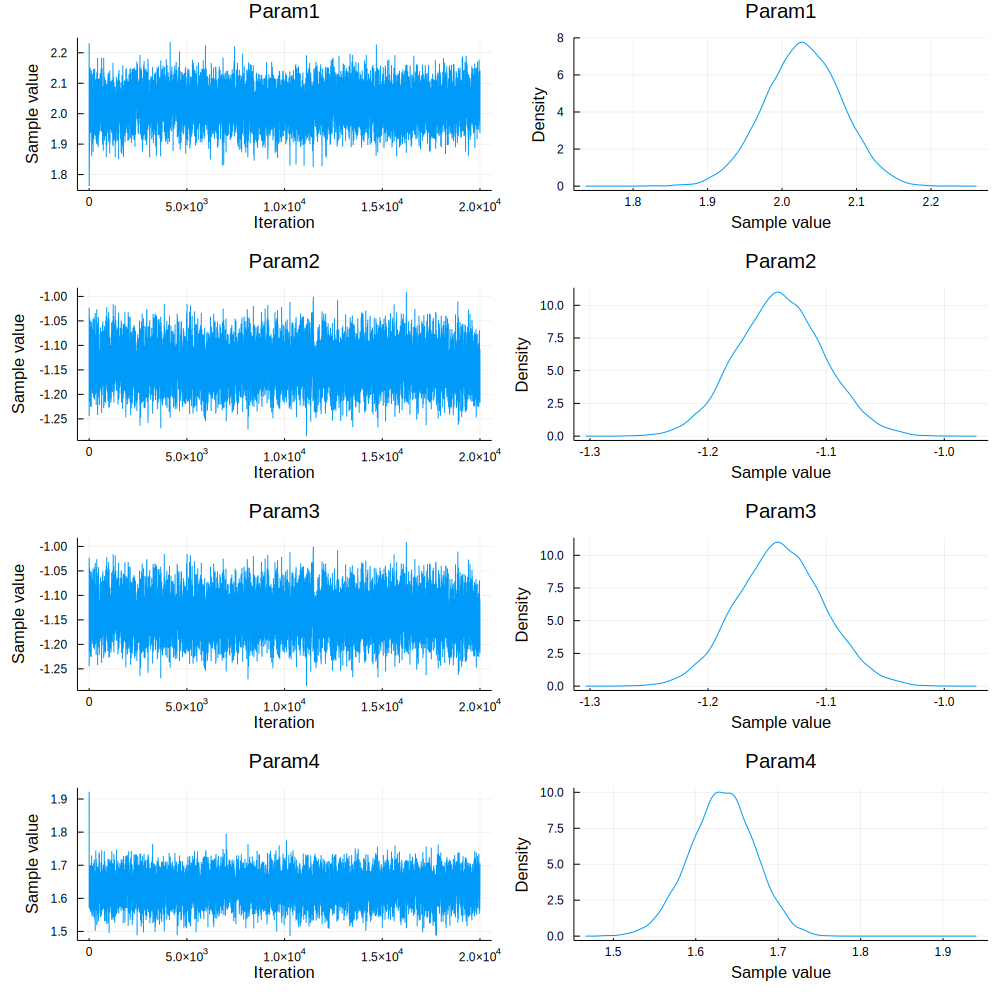

In [25]:
ω_cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
ω_cov_pos_sam[:, :, 1] = hcat(ω_cov_sam[ind_ω_cov_sam, 1], ω_cov_sam[ind_ω_cov_sam, 2], 
    ω_cov_sam[ind_ω_cov_sam .+ 1, 1], ω_cov_sam[ind_ω_cov_sam .+ 1, 2]);
ω_cov_chain = Chains(ω_cov_pos_sam);
pωcov = plot(ω_cov_chain)

In [28]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  2.11785  -1.18849
 -1.18849   1.66342

# Posterior Inference 

In [49]:
summary_table = Array{Float64, 2}(undef, 11, 5);
summary_table[1, :] = vcat(β[1, 1], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 1]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 1], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 2]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 2], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 1]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 1], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2]),
    quantile(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[1, 1], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 1]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 1], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(Σ[1, 2], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 2]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)], 2], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(Σ[2, 2], mean(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2]),
    quantile(Σ_sam[ind_Σ_sam[(N_pre_burn + 1):(N_sam + 1)] .+ 1, 2], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[1, 1], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 1]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(covω[1, 2], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 2]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam], 2], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(covω[2, 2], mean(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam] .+ 1, 2]),
    quantile(ω_cov_sam[ind_ω_cov_sam[(N_pre_burn + 1):N_sam] .+ 1, 2], [0.5, 0.025, 0.975]));
summary_table[11, :] = vcat(ϕ1, mean(vcat(ϕ_sam[1, (N_pre_burn + 1):N_sam], 
            ϕ_sam[2, (N_pre_burn + 1):N_sam])),
    quantile(vcat(ϕ_sam[1, (N_pre_burn + 1):N_sam], 
            ϕ_sam[2, (N_pre_burn + 1):N_sam]), [0.5, 0.025, 0.975]));
#summary_table[12, :] = vcat(ϕ1, mean(ϕ_sam[2, (N_pre_burn + 1):N_sam]),
#quantile(ϕ_sam[2, (N_pre_burn + 1):N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[1, 1] |    1.0 |  0.572 |  0.631 | -0.426 |  1.106 |
|      β[1, 2] |   -1.0 | -0.632 |  -0.68 | -1.289 |  0.433 |
|      β[2, 1] |   -5.0 | -4.948 | -4.948 | -5.097 | -4.796 |
|      β[2, 2] |    2.0 |  2.089 |  2.089 |  1.959 |  2.218 |
|      Σ[1, 1] |    2.0 |  0.258 |  0.258 |  0.212 |  0.308 |
|      Σ[1, 2] |   -1.0 | -0.133 | -0.132 | -0.167 | -0.101 |
|      Σ[2, 2] |    1.5 |  0.186 |  0.185 |  0.151 |  0.225 |
| cov(ω)[1, 1] |  2.118 |   2.03 |   2.03 |  1.931 |  2.129 |
| cov(ω)[1, 2] | -1.188 | -1.139 |  -1.14 | -1.211 | -1.066 |
| cov(ω)[2, 2] |  1.663 |  1.633 |  1.634 |  1.552 |  1.708 |
|           ϕ1 |    6.0 |  4.915 |  4.588 |  2.991 |  8.467 |


In [31]:
# MAE #
MAE1 = sum(abs.(Y_ord[M, 1] - Y_M_sam_mean[:, 1])) / 200;
MAE2 = sum(abs.(Y_ord[M, 2] - Y_M_sam_mean[:, 2])) / 200;
# calculate root mean square predictive error #
MAE = sum(abs.(Y_ord[M, :] - Y_M_sam_mean)) / 400;
round.([MAE1 MAE2 MAE], digits = 3)

1×3 Array{Float64,2}:
 0.558  0.504  0.531

In [32]:
# MAEL #
MAEL1 = (sum(abs.(ω_incp_obs[S, 1] - ω_incp_sam_mean[:, 1])) + 
    sum(abs.(ω_incp_obs[M, 1] - ω_incp_M_sam_mean[:, 1]))) / (N);
MAEL2 = (sum(abs.(ω_incp_obs[S, 2] - ω_incp_sam_mean[:, 2])) + 
    sum(abs.(ω_incp_obs[M, 2] - ω_incp_M_sam_mean[:, 2]))) / (N);
MAEL = (sum(abs.(ω_incp_obs[S, :] - ω_incp_sam_mean)) + 
    sum(abs.(ω_incp_obs[M, :] - ω_incp_M_sam_mean))) / (2 * N);
round.([MAEL1 MAEL2 MAEL], digits = 3)

1×3 Array{Float64,2}:
 0.307  0.275  0.291

In [33]:
# RMSPE #
MSPE1 = sum((Y_ord[M, 1] - Y_M_sam_mean[:, 1]).^2) / 200
RMSPE1 = sqrt(MSPE1); RMSPE1
MSPE2 = sum((Y_ord[M, 2] - Y_M_sam_mean[:, 2]).^2) / 200
RMSPE2 = sqrt(MSPE2); RMSPE2
# calculate root mean square predictive error #
MSPE = (sum((Y_ord[M, :] - Y_M_sam_mean).^2)) / (2 * 200)
RMSPE = sqrt(MSPE); 
round.([RMSPE1 RMSPE2 RMSPE], digits = 3)

1×3 Array{Float64,2}:
 0.707  0.631  0.67

In [34]:
# MSPEL #
MSEL1 = (sum((ω_incp_obs[S, 1] - ω_incp_sam_mean[:, 1]).^2) + 
    sum((ω_incp_obs[M, 1] - ω_incp_M_sam_mean[:, 1]).^2)) / (N);
MSEL2 = (sum((ω_incp_obs[S, 2] - ω_incp_sam_mean[:, 2]).^2) + 
    sum((ω_incp_obs[M, 2] - ω_incp_M_sam_mean[:, 2]).^2)) / (N);
MSEL = (sum((ω_incp_obs[S, :] - ω_incp_sam_mean).^2) + 
    sum((ω_incp_obs[M, :] - ω_incp_M_sam_mean).^2)) / (2 * N);
round.([MSEL1 MSEL2 MSEL], digits = 3)

1×3 Array{Float64,2}:
 0.156  0.12  0.138

In [35]:
# MSPEL only for 1000 obversed location #
MSEL1 = (sum((ω_incp_obs[S, 1] - ω_incp_sam_mean[:, 1]).^2)) / (N);
MSEL2 = (sum((ω_incp_obs[S, 2] - ω_incp_sam_mean[:, 2]).^2)) / (N);
MSEL = (sum((ω_incp_obs[S, :] - ω_incp_sam_mean).^2)) / (2 * N);
round.([MSEL1 MSEL2 MSEL], digits = 3)

1×3 Array{Float64,2}:
 0.105  0.08  0.093

In [36]:
# CRPS #
CRPS_U = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[M[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPS1 = sum(CRPS_U[:, 1]) / NM;
CRPS2 = sum(CRPS_U[:, 2]) / NM;
CRPS = sum(CRPS_U)/(2 * NM);
round.([CRPS1 CRPS2 CRPS], digits = 5)

1×3 Array{Float64,2}:
 -0.39671  -0.35531  -0.37601

In [37]:
# CRPSL #
CRPSL_S = [(sqrt(ω_incp_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) -
        ((ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j]) / sqrt(ω_incp_sam_var[i, j])) - 1)))
        for i in 1:n, j in 1:q];

CRPSL_U = [(sqrt(ω_incp_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[M[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) -
        ((ω_incp_obs[M[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (ω_incp_obs[M[i], j] - ω_incp_M_sam_mean[i, j]) / sqrt(ω_incp_M_sam_var[i, j])) - 1)))
        for i in 1:NM, j in 1:q];

CRPSL1 = (sum(CRPSL_U[:, 1]) + sum(CRPSL_S[:, 1])) / (n + NM);
CRPSL2 = (sum(CRPSL_U[:, 2]) + sum(CRPSL_S[:, 2])) / (n + NM);
CRPSL = (sum(CRPSL_U) + sum(CRPSL_S))/(2 * NM + 2 * n);
round.([CRPSL1 CRPSL2 CRPSL], digits = 5)

1×3 Array{Float64,2}:
 -0.21783  -0.19229  -0.20506

In [39]:
# CVG #
N_Inf_burn = 1;
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[M[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[M[i], j]))
    end
end
print(count_Y_M ./ 200);
print(round(sum(count_Y_M) / 400, digits = 3))

[0.94, 0.95]0.945

In [41]:
# CVGL over 1200 locations#
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
        ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
    end
end
for j in 1:q
    for i in 1:NM
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j])) < ω_incp_obs[M[i], j]) && 
        ((ω_incp_M_sam_mean[i, j] + 1.96 * sqrt(ω_incp_M_sam_var[i, j])) > ω_incp_obs[M[i], j]))
    end
end
print(round.(count_ω_incp ./ N, digits = 3))
print(round(sum(count_ω_incp) / (2*N), digits = 3))

[0.943, 0.951]0.947

In [42]:
# CVGL only for 1000 obversed location #
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
        ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
    end
end
print(count_ω_incp./1000);
print(round(sum(count_ω_incp)/2000, digits = 3))

[0.95, 0.956]0.953

In [43]:
# INT #
INT_U = [((2 * 1.96 * sqrt(Y_M_sam_var[i, j])) + 
                (2 / 0.05)*(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i]) - Y_ord[M[i], j]) * 
                (Y_ord[M[i], j] < (Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j]))) + 
                (2 / 0.05)*(Y_ord[M[i], j] - Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) * 
                (Y_ord[M[i], j] > (Y_M_sam_mean[i, j] + 
                1.96 * sqrt(Y_M_sam_var[i, j])))) for i in 1:NM, j in 1:q]

INT1 = (sum(INT_U[:, 1])) / (NM);
INT2 = (sum(INT_U[:, 2])) / (NM);
INT = (sum(INT_U))/(2 * NM);

round.([INT1 INT2 INT], digits = 5)

1×3 Array{Float64,2}:
 3.31625  2.83788  3.07707

In [44]:
# INTL #
INTL_S = [((2 * 1.96 * sqrt(ω_incp_sam_var[i, j])) + 
                (2 / 0.05)*(ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j]) - ω_incp_obs[S[i], j]) * 
                (ω_incp_obs[S[i], j] < (ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[S[i], j] - ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) * 
                (ω_incp_obs[S[i], j] > (ω_incp_sam_mean[i, j] + 
                1.96 * sqrt(ω_incp_sam_var[i, j])))) for i in 1:n, j in 1:q];

INTL_U = [((2 * 1.96 * sqrt(ω_incp_M_sam_var[i, j])) + 
                (2 / 0.05)*(ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j]) - ω_incp_obs[M[i], j]) * 
                (ω_incp_obs[M[i], j] < (ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j]))) + 
                (2 / 0.05)*(ω_incp_obs[M[i], j] - ω_incp_M_sam_mean[i, j] - 1.96 * sqrt(ω_incp_M_sam_var[i, j])) * 
                (ω_incp_obs[M[i], j] > (ω_incp_M_sam_mean[i, j] + 
                1.96 * sqrt(ω_incp_M_sam_var[i, j])))) for i in 1:NM, j in 1:q];
INTL1 = (sum(INTL_S[:, 1]) + sum(INTL_U[:, 1])) / (n + NM);
INTL2 = (sum(INTL_S[:, 2]) + sum(INTL_U[:, 2])) / (n + NM);
INTL = (sum(INTL_U) + sum(INTL_S))/(2 * NM + 2*n);

round.([INTL1 INTL2 INTL], digits = 5)

1×3 Array{Float64,2}:
 1.84281  1.54567  1.69424

In [47]:
@save "../results/BSLMC_results.jld" ϕ_sam A_sam ω_incp_sam_mean ω_incp_sam_var ω_incp_M_sam_mean ω_incp_M_sam_var Y_M_sam_mean Y_M_sam_var Y_ord S M K p q N_sam N_pre_burn

In [68]:
incp = [mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 1])
    mean(γ_sam[ind_γ_sam[(N_pre_burn + 1):(N_sam + 1)], 2])];

In [70]:
lll = fill(1.0, (n, 1));
ω_pos_BSLMC_mean = ω_incp_sam_mean - lll * transpose(incp);

In [71]:
@save "../results/ω_incp_obs_pos_qt_BSLMC.jld"  ω_pos_BSLMC_mean